<a href="https://colab.research.google.com/github/fcoliveira-utfpr/agrometeorologia/blob/main/05_bh_climatologico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Inserindo informações**
---

In [56]:
# ============================================================
municipio = "Posse" ###### Nome aqui entre aspas

estado = "GO" ###### Sigla do estado entre aspas

# ============================================================
# ============================================================

#importando bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config inlineBackend.figure_formats = ['svg']

# **Carrega base climática TerraClimate 1991-2020**
---

In [57]:
# Carrega base climática local
# ============================================================
url = "https://raw.githubusercontent.com/fcoliveira-utfpr/agrometeorologia/refs/heads/main/TerraClimate_PR_PET_Normal_1991_2020.csv"
df = pd.read_csv(url)

# Separa colunas categóricas
cidade = df['Município']
uf = df['Estado']

# Converte valores com vírgula para ponto e numérico
df_valores = df.drop(columns=['Município', 'Estado'])
df_valores = df_valores.replace({',': '.'}, regex=True)
df_valores = df_valores.apply(pd.to_numeric, errors='coerce')

# Reconstrói o df
df = df_valores.copy()
df['Município'] = cidade
df['Estado'] = uf

# Filtra município e estado
df = df[(df['Município'] == municipio) & (df['Estado'] == estado)].copy()

# Correção: Alterar a lista de meses para corresponder ao formato das colunas (ex: 'PET_01')
meses = [f"{i:02d}" for i in range(1, 13)]

pet = [df[f"PET_{m}"].values[0] for m in meses]
chuva = [df[f"PR_{m}"].values[0] for m in meses]

mes = ["jan","fev","mar","abr","maio","jun","jul","ago","set","out","nov","dez"]

df_bh = pd.DataFrame(
    {
      'Meses': mes,
      'P (mm/mês)': chuva,
      'ETP (mm/mês)': pet,
    }
)

tiempo = 'PET_PR_Normal'

#para baixar os dados tire o # da última linha
from google.colab import files
df_bh.to_excel(f'{municipio}_{tiempo}.xlsx')
#files.download(f'{municipio}_{tiempo}.xlsx')

df_bh

,Meses,P (mm/mês),ETP (mm/mês)
0,jan,203.400000,128.730000
1,fev,189.533333,106.286667
2,mar,196.266667,117.300000
3,abr,116.933333,109.263333
4,maio,14.033333,106.800000
5,jun,3.333333,102.033333
6,jul,1.300000,114.986667
7,ago,4.366667,134.523333
8,set,18.033333,141.426667
9,out,99.466667,149.146667


# **balanço hídrico climatológico de Thothwaite-Mather**
---

In [58]:
# ============================================================
# 1) Parâmetros
# ============================================================
CAD = 100.0
tol = 1e-6

df_bh['CAD'] = 100.0

# ============================================================
# Saldo hídrico
# ============================================================
df_bh['P-ETP'] = df_bh['P (mm/mês)'] - df_bh['ETP (mm/mês)']

# ============================================================
# Inicialização
# ============================================================
ARM = [df_bh['CAD'].iloc[0]]      # solo cheio no início
NEG_ACUM = [0.0]                  # sem déficit acumulado inicial

# ============================================================
# ARM – Armazenamento de água no solo
# ============================================================
# ============================================================
# Loop mensal
# ============================================================
for i in range(len(df_bh)):
    p_etp = df_bh['P-ETP'].iloc[i]
    cad = df_bh['CAD'].iloc[i]
    arm_prev = ARM[-1]
    neg_prev = NEG_ACUM[-1]

    if p_etp < 0:
        # Acumula déficit
        neg = neg_prev + p_etp
        arm = cad * np.exp(neg / cad)

    else:
        # Reposição hídrica
        arm = min(arm_prev + p_etp, cad)

        # Recalcula NEG.ACUM pela inversão
        if arm < cad:
            neg = cad * np.log(arm / cad)
        else:
            neg = 0.0

    ARM.append(arm)
    NEG_ACUM.append(neg)

# Remove o valor inicial extra
df_bh['ARM (mm/mês)'] = ARM[1:]
df_bh['NEG.ACUM (mm)'] = NEG_ACUM[1:]

# ============================================================
# ALT – Variação do armazenamento
# ============================================================
df_bh['ALT (mm/mês)'] = df_bh['ARM (mm/mês)'].diff().fillna(0)

# ============================================================
# ETR – Evapotranspiração real
# ============================================================
df_bh['ETR (mm/mês)'] = np.where(
    df_bh['P-ETP'] < 0,
    df_bh['P (mm/mês)'] + df_bh['ALT (mm/mês)'].abs(),
    df_bh['ETP (mm/mês)']
)

# ============================================================
# DEF – Deficiência hídrica
# ============================================================
df_bh['DEF (mm/mês)'] = df_bh['ETP (mm/mês)'] - df_bh['ETR (mm/mês)']

# ============================================================
# EXC – Excedente hídrico
# ============================================================
df_bh['EXC (mm/mês)'] = np.where(
    (df_bh['P-ETP'] > 0) & (df_bh['ARM (mm/mês)'] == df_bh['CAD']),
    df_bh['P-ETP'] - df_bh['ALT (mm/mês)'],
    0
)

tiempo = 'BH_climatologico'

#para baixar os dados tire o # da última linha
from google.colab import files
df_bh.to_excel(f'{municipio}_{tiempo}.xlsx')
#files.download(f'{municipio}_{tiempo}.xlsx')

df_bh


,Meses,P (mm/mês),ETP (mm/mês),CAD,P-ETP,ARM (mm/mês),NEG.ACUM (mm),ALT (mm/mês),ETR (mm/mês),DEF (mm/mês),EXC (mm/mês)
0,jan,203.400000,128.730000,100.0,74.670000,100.000000,0.000000,0.000000,128.730000,0.000000,74.670000
1,fev,189.533333,106.286667,100.0,83.246667,100.000000,0.000000,0.000000,106.286667,0.000000,83.246667
2,mar,196.266667,117.300000,100.0,78.966667,100.000000,0.000000,0.000000,117.300000,0.000000,78.966667
3,abr,116.933333,109.263333,100.0,7.670000,100.000000,0.000000,0.000000,109.263333,0.000000,7.670000
4,maio,14.033333,106.800000,100.0,-92.766667,39.547541,-92.766667,-60.452459,74.485792,32.314208,0.000000
5,jun,3.333333,102.033333,100.0,-98.700000,14.739095,-191.466667,-24.808446,28.141779,73.891554,0.000000
6,jul,1.300000,114.986667,100.0,-113.686667,4.728636,-305.153333,-10.010459,11.310459,103.676207,0.000000
7,ago,4.366667,134.523333,100.0,-130.156667,1.286686,-435.310000,-3.441950,7.808617,126.714717,0.000000
8,set,18.033333,141.426667,100.0,-123.393333,0.374612,-558.703333,-0.912074,18.945407,122.481259,0.000000
9,out,99.466667,149.146667,100.0,-49.680000,0.227942,-608.383333,-0.146670,99.613337,49.533330,0.000000


# Gráfico **Extrato do Balanço Hídrico**
---

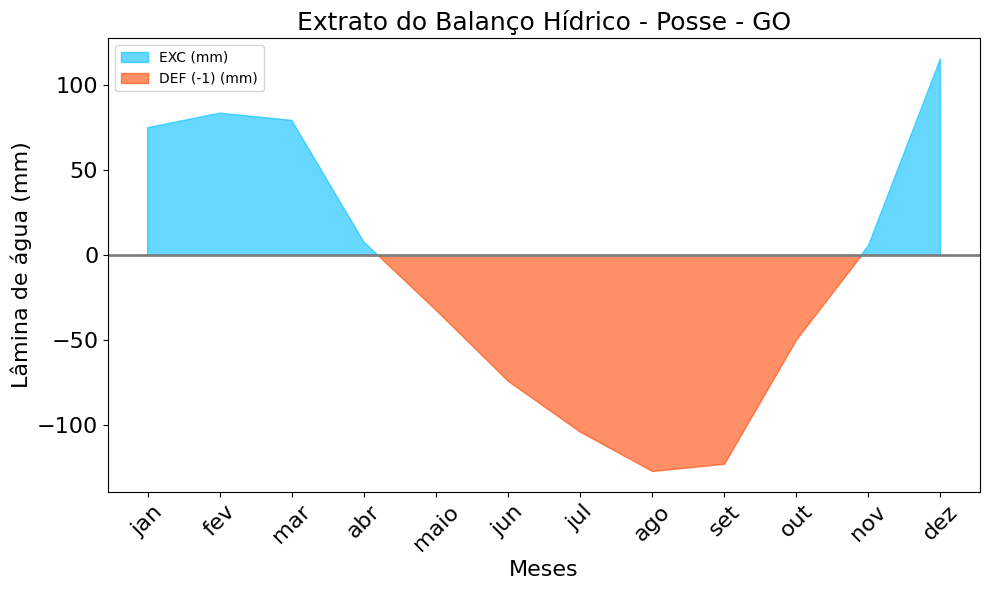

In [59]:
# Auxiliares para gráfico
df_bh['DEF (-1) (mm/mês)'] = df_bh['DEF (mm/mês)'].apply(
    lambda x: 0 if x == 0 else x * (-1))

df_bh['extrat'] = df_bh['EXC (mm/mês)'] + df_bh['DEF (-1) (mm/mês)']

x = df_bh["Meses"]
y = df_bh["extrat"]

y_pos = y.where(y >= 0, np.nan)
y_neg = y.where(y < 0, np.nan)

plt.figure(figsize=(10, 6))

# Área positiva
plt.fill_between(
    x, y, 0,
    where=(y >= 0),
    interpolate=True,
    color='deepskyblue',
    alpha=0.6,
    label='EXC (mm)'
)


# Área negativa
plt.fill_between(
    x, y, 0,
    where=(y < 0),
    interpolate=True,
    color='orangered',
    alpha=0.6,
    label='DEF (-1) (mm)'
)

# Linha zero
plt.axhline(0, color = 'gray', linewidth = 2, linestyle = '-')

titulo = plt.title(f'Extrato do Balanço Hídrico - {municipio} - {estado}', fontsize = 18)
textox = plt.xlabel("Meses", fontsize = 16)
textoy = plt.ylabel("Lâmina de água (mm)", fontsize = 16)

texto_x = plt.tick_params(axis='x', which='major', labelsize=16, rotation = 45)
texto_y = plt.tick_params(axis='y', which='major', labelsize=16, rotation = 0)

plt.legend()
plt.tight_layout()
plt.show()

# Gráfico **Água no solo**
---

/tmp/ipython-input-3437305065.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ratuloposicao = axs.set_xticklabels(x, rotation=45, ha='right')


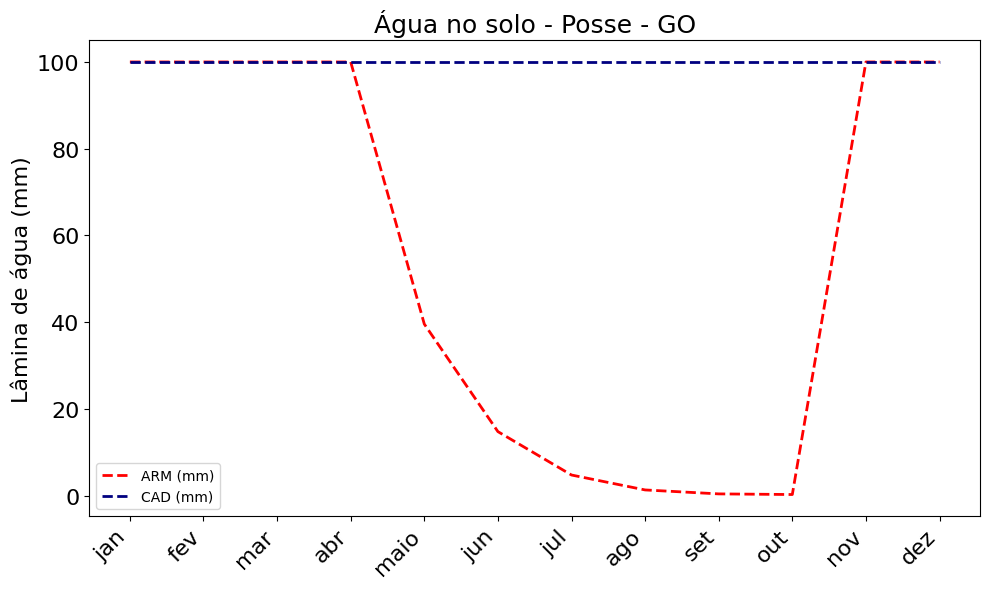

In [60]:
#gráfico de água no solo
figs, axs = plt.subplots(figsize = (10, 6))
x = df_bh["Meses"]
ycad = df_bh['CAD']
yarm = df_bh['ARM (mm/mês)']
ARM = axs.plot(x, yarm, color = 'red', linewidth = 2, linestyle = '--',label = 'ARM (mm)')
CAD = axs.plot(x, ycad, color = 'navy', linewidth = 2, linestyle = '--',label = 'CAD (mm)')
titulo = axs.set_title(f'Água no solo - {municipio} - {estado}', fontsize = 18)
textox = axs.set_xlabel(None)
textoy = axs.set_ylabel('Lâmina de água (mm)', fontsize = 16)
texto_x = axs.tick_params(axis='x', which='major', labelsize=16, rotation = 45)
texto_y = axs.tick_params(axis='y', which='major', labelsize=16, rotation = 0)
ratuloposicao = axs.set_xticklabels(x, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Gráfico **Retiradas e reposições de água**
---

/tmp/ipython-input-580054134.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ratuloposicao = axs.set_xticklabels(x, rotation=45, ha='right')


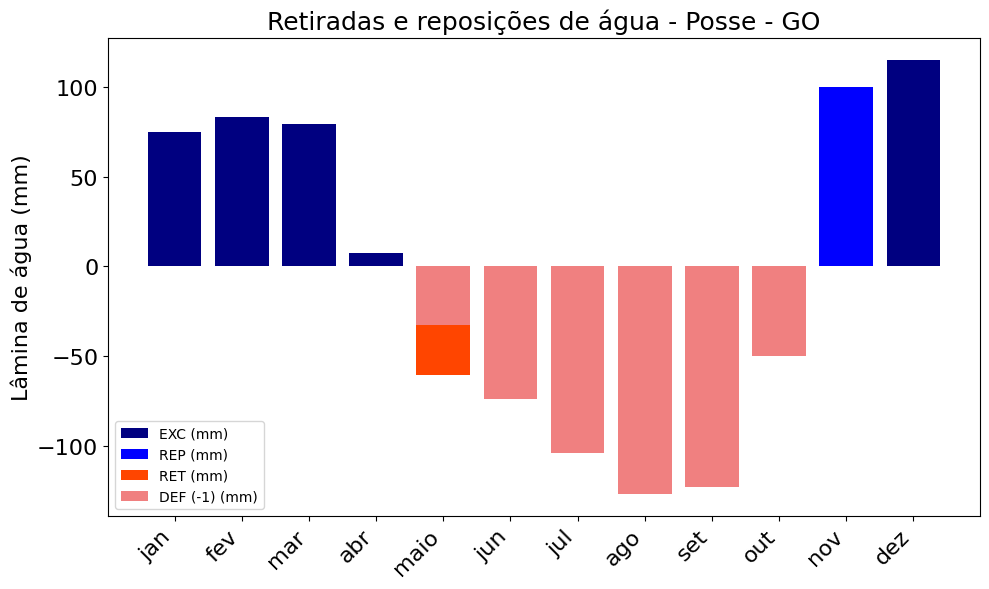

In [61]:
# Auxiliares para gráfico
df_bh['DEF (-1) (mm/mês)'] = df_bh['DEF (mm/mês)'].apply(
    lambda x: 0 if x == 0 else x * (-1))
df_bh['REP (mm/mês)'] = df_bh['ALT (mm/mês)'].apply(lambda x: x if x >= 0 else 0)
df_bh['RET (mm/mês)'] = df_bh['ALT (mm/mês)'].apply(lambda x: x if x < 0 else 0)

figs, axs = plt.subplots(figsize = (10, 6))
x = df_bh["Meses"]
yexc = df_bh['EXC (mm/mês)']
yrep = df_bh['REP (mm/mês)']
yret = df_bh['RET (mm/mês)']
ydef = df_bh['DEF (-1) (mm/mês)']

EXC = axs.bar(x, yexc, color = 'navy', linewidth = 2, linestyle = '--',label = 'EXC (mm)')
REP = axs.bar(x, yrep, color = 'blue', linewidth = 2, linestyle = '--',label = 'REP (mm)')
RET = axs.bar(x, yret, color = 'orangered', linewidth = 2, linestyle = '--',label = 'RET (mm)')
DEF = axs.bar(x, ydef, color = 'lightcoral', linewidth = 2, linestyle = '--',label = 'DEF (-1) (mm)')
titulo = axs.set_title(f'Retiradas e reposições de água - {municipio} - {estado}', fontsize = 18)
textox = axs.set_xlabel(None)
textoy = axs.set_ylabel('Lâmina de água (mm)', fontsize = 16)
texto_x = axs.tick_params(axis='x', which='major', labelsize=16, rotation = 45)
texto_y = axs.tick_params(axis='y', which='major', labelsize=16, rotation = 0)
ratuloposicao = axs.set_xticklabels(x, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Gráfico **Balanço hídrico**
---

/tmp/ipython-input-1812783135.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ratuloposicao = axs.set_xticklabels(x, rotation=45, ha='right')


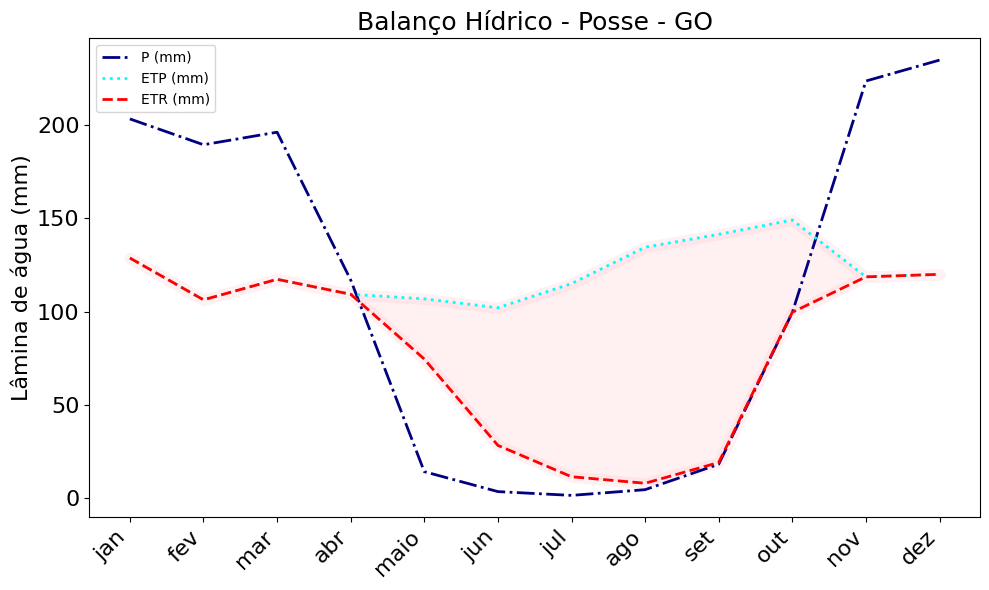

In [62]:
#gráfico de balanço hídrico
figs, axs = plt.subplots(figsize = (10, 6))
x = df_bh["Meses"]
yp = df_bh['P (mm/mês)']
yetp = df_bh['ETP (mm/mês)']
yetr = df_bh['ETR (mm/mês)']

P = axs.plot(x, yp, color = 'navy', linewidth = 2, linestyle = 'dashdot', label = 'P (mm)')
ETP = axs.plot(x, yetp, color = 'cyan', linewidth = 2, linestyle = 'dotted', label = 'ETP (mm)')
ETR = axs.plot(x, yetr, color = 'red', linewidth = 2, linestyle = 'dashed',label = 'ETR (mm)')
titulo = axs.set_title(f'Balanço Hídrico - {municipio} - {estado}', fontsize = 18)
textox = axs.set_xlabel(None)
textoy = axs.set_ylabel('Lâmina de água (mm)', fontsize = 16)
texto_x = axs.tick_params(axis='x', which='major', labelsize=16, rotation = 45)
texto_y = axs.tick_params(axis='y', which='major', labelsize=16, rotation = 0)
ratuloposicao = axs.set_xticklabels(x, rotation=45, ha='right')
axs.fill_between(x, yetp, yetr,
                 alpha = 0.2,
                 color = 'lightpink',
                 #hatch = 'o',
                 linestyle = '-',
                 linewidth = 8
                 )
plt.legend()
plt.tight_layout()
plt.show()